# Laboratorium 4

### Konfiguracja

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.collections as mcoll
import matplotlib.colors as mcolors
from matplotlib.widgets import Button
import json as js

TOLERANCE = 0.15

def dist(point1, point2):
    return np.sqrt(np.power(point1[0] - point2[0], 2) + np.power(point1[1] - point2[1], 2))

class _Button_callback(object):
    def __init__(self, scenes):
        self.i = 0
        self.scenes = scenes
        self.adding_points = False
        self.added_points = []
        self.adding_lines = False
        self.added_lines = []
        self.adding_rects = False
        self.added_rects = []

    def set_axes(self, ax):
        self.ax = ax
        
    def next(self, event):
        self.i = (self.i + 1) % len(self.scenes)
        self.draw(autoscaling = True)

    def prev(self, event):
        self.i = (self.i - 1) % len(self.scenes)
        self.draw(autoscaling = True)
        
    def add_point(self, event):
        self.adding_points = not self.adding_points
        self.new_line_point = None
        if self.adding_points:
            self.adding_lines = False
            self.adding_rects = False
            self.added_points.append(PointsCollection([]))
         
    def add_line(self, event):   
        self.adding_lines = not self.adding_lines
        self.new_line_point = None
        if self.adding_lines:
            self.adding_points = False
            self.adding_rects = False
            self.added_lines.append(LinesCollection([]))

    def add_rect(self, event):
        self.adding_rects = not self.adding_rects
        self.new_line_point = None
        if self.adding_rects:
            self.adding_points = False
            self.adding_lines = False
            self.new_rect()
    
    def new_rect(self):
        self.added_rects.append(LinesCollection([]))
        self.rect_points = []
    
    def on_click(self, event):
        if event.inaxes != self.ax:
            return
        new_point = (event.xdata, event.ydata)
        if self.adding_points:
            self.added_points[-1].add_points([new_point])
            self.draw(autoscaling = False)
        elif self.adding_lines:
            if self.new_line_point is not None:
                self.added_lines[-1].add([self.new_line_point, new_point])
                self.new_line_point = None
                self.draw(autoscaling = False)
            else:
                self.new_line_point = new_point
        elif self.adding_rects:
            if len(self.rect_points) == 0:
                self.rect_points.append(new_point)
            elif len(self.rect_points) == 1:
                self.added_rects[-1].add([self.rect_points[-1], new_point])
                self.rect_points.append(new_point)
                self.draw(autoscaling = False)
            elif len(self.rect_points) > 1:
                if dist(self.rect_points[0], new_point) < (np.mean([self.ax.get_xlim(), self.ax.get_ylim()])*TOLERANCE):
                    self.added_rects[-1].add([self.rect_points[-1], self.rect_points[0]])
                    self.new_rect()
                else:    
                    self.added_rects[-1].add([self.rect_points[-1], new_point])
                    self.rect_points.append(new_point)
                self.draw(autoscaling = False)
        
    def draw(self, autoscaling = True):
        if not autoscaling:
            xlim = self.ax.get_xlim()
            ylim = self.ax.get_ylim()
        self.ax.clear()
        for collection in (self.scenes[self.i].points + self.added_points):
            if len(collection.points) > 0:
                self.ax.scatter(*zip(*(np.array(collection.points))), **collection.kwargs)
        for collection in (self.scenes[self.i].lines + self.added_lines + self.added_rects):
            self.ax.add_collection(collection.get_collection())
        self.ax.autoscale(autoscaling)
        if not autoscaling:
            self.ax.set_xlim(xlim)
            self.ax.set_ylim(ylim)
        plt.draw()


### Interfejsy

[Dostępne kolory](https://matplotlib.org/3.1.1/gallery/color/named_colors.html)

[Dostępne znaczniki punktów](https://matplotlib.org/3.1.1/api/markers_api.html#module-matplotlib.markers)

In [2]:
class Scene:
    def __init__(self, points=[], lines=[]):
        self.points=points
        self.lines=lines

class PointsCollection:
    def __init__(self, points, **kwargs):
        self.points = points
        self.kwargs = kwargs
    
    def add_points(self, points):
        self.points = self.points + points

class LinesCollection:
    def __init__(self, lines, **kwargs):
        self.lines = lines
        self.kwargs = kwargs
        
    def add(self, line):
        self.lines.append(line)
        
    def get_collection(self):
        return mcoll.LineCollection(self.lines, **self.kwargs)
    
class Plot:
    def __init__(self, scenes = [Scene()], json = None):
        if json is None:
            self.scenes = scenes
        else:
            self.scenes = [Scene([PointsCollection(pointsCol) for pointsCol in scene["points"]], 
                                 [LinesCollection(linesCol) for linesCol in scene["lines"]]) 
                           for scene in js.loads(json)]
        
    def __configure_buttons(self):
        plt.subplots_adjust(bottom=0.2)
        ax_prev = plt.axes([0.6, 0.05, 0.15, 0.075])
        ax_next = plt.axes([0.76, 0.05, 0.15, 0.075])
        ax_add_point = plt.axes([0.44, 0.05, 0.15, 0.075])
        ax_add_line = plt.axes([0.28, 0.05, 0.15, 0.075])
        ax_add_rect = plt.axes([0.12, 0.05, 0.15, 0.075])
        b_next = Button(ax_next, 'Następny')
        b_next.on_clicked(self.callback.next)
        b_prev = Button(ax_prev, 'Poprzedni')
        b_prev.on_clicked(self.callback.prev)
        b_add_point = Button(ax_add_point, 'Dodaj punkt')
        b_add_point.on_clicked(self.callback.add_point)
        b_add_line = Button(ax_add_line, 'Dodaj linię')
        b_add_line.on_clicked(self.callback.add_line)
        b_add_rect = Button(ax_add_rect, 'Dodaj figurę')
        b_add_rect.on_clicked(self.callback.add_rect)
        return [b_prev, b_next, b_add_point, b_add_line, b_add_rect]
    
    def add_scene(self, scene):
        self.scenes.append(scene)
    
    def add_scenes(self, scenes):
        self.scenes = self.scenes + scenes

    def toJson(self):
        return js.dumps([{"points": [np.array(pointCol.points).tolist() for pointCol in scene.points], 
                          "lines":[linesCol.lines for linesCol in scene.lines]} 
                         for scene in self.scenes])    
     
    def get_added_points(self):
        if self.callback:
            return self.callback.added_points
        else:
            return None
  
    def get_added_lines(self):
        if self.callback:
            return self.callback.added_lines
        else:
            return None
        
    def get_added_figure(self):
        if self.callback:
            return self.callback.added_rects
        else:
            return None
    
    def get_added_elements(self):
        if self.callback:
            return Scene(self.callback.added_points, self.callback.added_lines+self.callback.added_rects)
        else:
            return None
    
    def draw(self):
        plt.close()
        fig = plt.figure()
        self.callback = _Button_callback(self.scenes)
        self.widgets = self.__configure_buttons()
        ax = plt.axes(autoscale_on = False)
        self.callback.set_axes(ax)
        fig.canvas.mpl_connect('button_press_event', self.callback.on_click)
        plt.show()
        self.callback.draw()
        

### Przykłady użycia

##### Proste rysowanie

Należy utworzyć zmienną z obiuektem `Plot`, który przyjmuje jako parametr konstruktora listę scen lub string ze scenami w formacie json. Następnie po dodaniu wszystkich, na samym końcu programu, należy wywołać jego metodę `draw()`.

In [ ]:
%matplotlib notebook

scenes=[Scene([PointsCollection([(1, 2), (3, 1.5), (2, -1)]), 
               PointsCollection([(5, -2), (2, 2), (-2, -1)], color='green', marker = "^")], 
              [LinesCollection([[(1,2),(2,3)], [(0,1),(1,0)]])]), 
        Scene([PointsCollection([(1, 2), (3, 1.5), (2, -1)], color='red'), 
               PointsCollection([(5, -2), (2, 2), (-2, 1)], color='black')], 
              [LinesCollection([[(-1,2),(-2,3)], [(0,-1),(-1,0)]])])]

plot = Plot(scenes)
plot.draw() 


###### Zapis i odczyt z pliku

Klasa Plot posiada metodę `toJson()`, która zwraca string zawierający listę scen w formacie JSON. Taki string można normalnie zapisać do pliku stosując normalne sposoby dostępne w Pythonie. Wczytanie listy scen z pliku dokonuje się poprzez podanie parametru `json` w kostruktorze `Plot`.

In [ ]:
scenes=[Scene([PointsCollection([(-2, -1)], color='green', marker = "^")], 
              [LinesCollection([[(1,2),(2,3)], [(0,1),(1,0)]])]), 
        Scene([PointsCollection([(1, 2), (3, 1.5)], color='red'), 
               PointsCollection([(5, -2)], color='black')])]
plot = Plot(scenes)

with open('somefile.json', 'w') as file:
    file.write(plot.toJson())
    
#somefile.txt: [{"points": [[[-2, -1]]], "lines": [[[[1, 2], [2, 3]], [[0, 1], [1, 0]]]]}, {"points": [[[1.0, 2.0], [3.0, 1.5]], [[5, -2]]], "lines": []}]
    
with open('somefile.json', 'r') as file:
    json = file.read()
    
plot2 = Plot(json=json)
plot2.draw()

##### Operowanie na dodanych punktach

Możemy bardzo łatwo rysować nowe punkty i linie. Aby je później wykorzystać sugerowanym sposobem jest utworzenie nowej komórki, w której utworzymy nowy `Plot` i skorzystamy z metod `get_added_points()` i `get_added_points()` lub `get_added_elements()` (zwraca scenę) z pierwszego `Plot`u.

In [ ]:
#Dodaj tu punkty, figury i/lub odcinki!
plot1 = Plot()
plot1.draw()

In [ ]:
plot2 = Plot([plot1.get_added_elements()])
plot2.draw()

### Rozwiązanie

#### Struktury i wprowadzanie wielokąta

In [212]:
class Point():
    def __init__(self, x, y):
        self.x = x
        self.y = y
        self.segment = None
        self.position = None
        self.type = None
        self.chain = None

    def add_segment(self, segment, t):
        self.segment = segment
        self.position = t
        
    def __str__(self):
        return '('+str(self.x)+', '+str(self.y)+'): '+str(self.chain)
    
    def __repr__(self):
        return '('+str(self.x)+', '+str(self.y)+'): '+str(self.chain)+'\n'
    
    def __lt__(self, other):
        return self.y > other.y
        
class Segment():
    def __init__(self, b, e):
        self.b = b
        self.e = e
        b.add_segment(self, 'b')
        e.add_segment(self, 'e')
        
    def __str__(self):
        return '['+str(self.b)+', '+str(self.e)+']'

    def __repr__(self):
        return '['+str(self.b)+', '+str(self.e)+']\n'
        
def file_to_data(filename):
    points = []
    segments = []
    with open(filename) as json_file:
        data = json.load(json_file)
        #print(data[0]['lines'][0])
        for s in data[0]['lines'][0]:
            if s:
                p1 = Point(s[0][0], s[0][1])
                p2 = Point(s[1][0], s[1][1])
                seg = Segment(p1, p2)
                points.append(p1)
                #points.append(p2)
                segments.append(seg)
            
    return points, segments

def data_to_file(plot, filename):
    with open(filename, 'w') as file:
        file.write(plot.toJson())

<IPython.core.display.Javascript object>


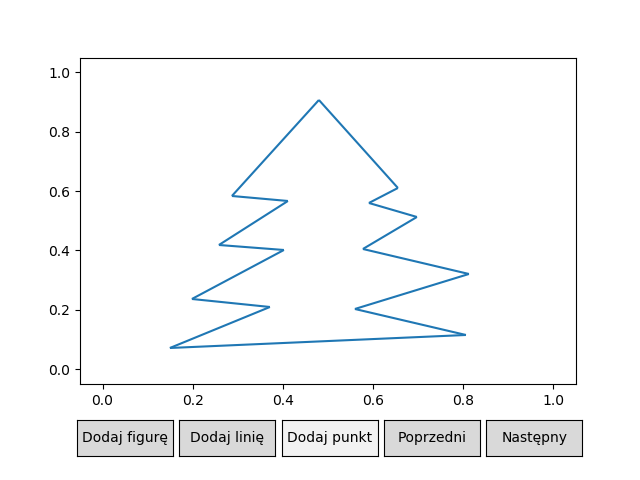

In [271]:
%matplotlib notebook
plot = Plot()
plot.draw()

In [272]:
plot2 = Plot([plot.get_added_elements()])
data_to_file(plot2, 'figure.json')

In [273]:
points, segments = file_to_data('figure.json')

In [250]:
points1, segments1 = file_to_data('fig1.json')

In [269]:
points2, segments2 = file_to_data('fig2.json')

In [252]:
pointsC, segmentsC = file_to_data('convex.json')

#### Sprawdzanie y-monotoniczności

In [253]:
def get_max_min_points_index(points):
    i_max = i_min = 0
    for j in range(len(points)):
        if points[j].y>points[i_max].y:
            i_max = j
        if points[j].y<points[i_min].y:
            i_min = j
            
    return i_max, i_min

def is_y_monotonic(points):
    i_max, i_min = get_max_min_points_index(points)
    
    i = i_max
    while not i==i_min:
        #print(points[i])
        j = (i+1) % len(points)
        if points[j].y > points[i].y:
            return False
        i = j  
        
    i = i_min
    while not i==i_max:
        #print(points[i])
        j = (i+1) % len(points)
        if points[j].y < points[i].y:
            return False
        i = j
        
    return True 

In [260]:
print(is_y_monotonic(points1))

True


#### Podział punktów wielokąta

In [257]:
def det(a, b, c):
    return ((b.y-a.y)*(c.x-a.x)-(c.y-a.y)*(b.x-a.x))

def transform_points(p):
    return (p.x, p.y)

def transform(segment):
    return [(segment.b.x, segment.b.y), (segment.e.x, segment.e.y)]

def label_points(points, segments, eps = 10**(-6)):
    l = len(points)
            
    initial = []
    final = []
    connective = []
    dividing = []
    proper = []
    
    for i in range(l):
        succ = points[(i+1)%l]
        pred = points[(i-1)%l]
        p = points[i]
        
        d = det(succ, p, pred)
        
        if succ.y < p.y and pred.y < p.y:
            if d>eps:
                initial.append(p)
                p.type = "initial"
            if d<eps:
                dividing.append(p)
                p.type = "dividing"
        elif succ.y > p.y and pred.y > p.y:
            if d>eps:
                final.append(p)
                p.type = "final"
            if d<eps:
                connective.append(p)
                p.type = "connective"
        else:
            proper.append(p)
            p.type = "proper"
        
    sc = [Scene([PointsCollection([transform_points(x) for x in initial], color="green"), 
                     PointsCollection([transform_points(x) for x in final], color="red"),
                    PointsCollection([transform_points(x) for x in connective], color="magenta"),
                    PointsCollection([transform_points(x) for x in dividing], color="blue"),
                    PointsCollection([transform_points(x) for x in proper], color="brown")],
         [LinesCollection([transform(x) for x in segments])])]
    return sc
    

green: initial
red: final
magenta: connective
blue: dividing
brown: proper


<IPython.core.display.Javascript object>


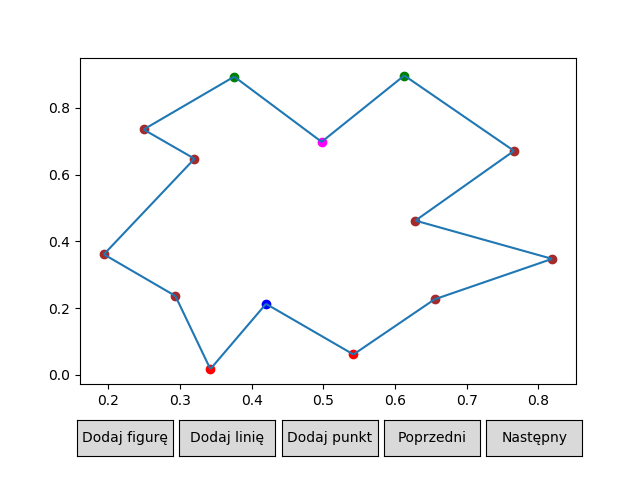

In [258]:
%matplotlib notebook
scenes = label_points(points, segments)
plot = Plot(scenes)
print("green: initial")
print("red: final")
print("magenta: connective")
print("blue: dividing")
print("brown: proper")
plot.draw()

#### Traingulacja wielokąta y-monotonicznego

In [244]:
def separate(points):
    i_max, i_min = get_max_min_points_index(points)
    
    i = i_max
    while not i==i_min:
        j = (i+1) % len(points)
        points[j].chain = -1
        i = j  
        
    i = i_min
    while not i==i_max:
        j = (i+1) % len(points)
        points[j].chain = 1
        i = j

    return sorted(points) 

def in_polygon(p, q, top, eps=10**(-6)):
    d = det(p, top, q)
    return top.chain*d < -eps

def triangle(points, segments):
    ordered = separate(points)
    diam = []
    stack = []
    
    sc = [Scene([],
         [LinesCollection([transform(x) for x in segments])])]
    
    stack.append(ordered[0])
    stack.append(ordered[1])
    
    for p in ordered[2:]:
        print(stack)
        prev = stack[-1]
        sc.append(Scene([PointsCollection([transform_points(x) for x in stack]),
                         PointsCollection([transform_points(p)])],
             [LinesCollection([transform(x) for x in segments]), 
              LinesCollection([transform(x) for x in diam])]))
        if not prev.chain == p.chain:
            while stack:
                q = stack.pop()
                diam.append(Segment(q, p))
            stack.append(prev)
            stack.append(p)

        else:
            st = stack.pop()
            stop = False
            while stack and not stop:
                q = stack.pop()
                if in_polygon(p, q, st):
                    diam.append(Segment(q, p))
                    st = q
                else:
                    stop = True
            
               
            stack.append(q)
            if not q==st:
                stack.append(st)
            stack.append(p)

    sc.append(Scene([PointsCollection([transform_points(x) for x in stack])],
             [LinesCollection([transform(x) for x in segments]), 
              LinesCollection([transform(x) for x in diam])]))
        
        
    return sc

[(0.4044291834677419, 1.0352242264093137): 1
, (0.6439453125, 0.8532389322916667): 1
]
[(0.4044291834677419, 1.0352242264093137): 1
, (0.4842678931451613, 0.7588761871936274): 1
]
[(0.4044291834677419, 1.0352242264093137): 1
, (0.4842678931451613, 0.7588761871936274): 1
, (0.6727759576612903, 0.7150649126838236): 1
]
[(0.4044291834677419, 1.0352242264093137): 1
, (0.4975743447580645, 0.6308124617034314): 1
]
[(0.4044291834677419, 1.0352242264093137): 1
, (0.4975743447580645, 0.6308124617034314): 1
, (0.7104775705645161, 0.5533002068014705): 1
]
[(0.4044291834677419, 1.0352242264093137): 1
, (0.5086630544354839, 0.46904775582107844): 1
]
[(0.5086630544354839, 0.46904775582107844): 1
, (0.33124369959677424, 0.44208697150735293): -1
]
[(0.33124369959677424, 0.44208697150735293): -1
, (0.7260017641129033, 0.4353467754289216): 1
]
[(0.33124369959677424, 0.44208697150735293): -1
, (0.524187247983871, 0.344354128370098): 1
]
[(0.33124369959677424, 0.44208697150735293): -1
, (0.524187247983871

<IPython.core.display.Javascript object>


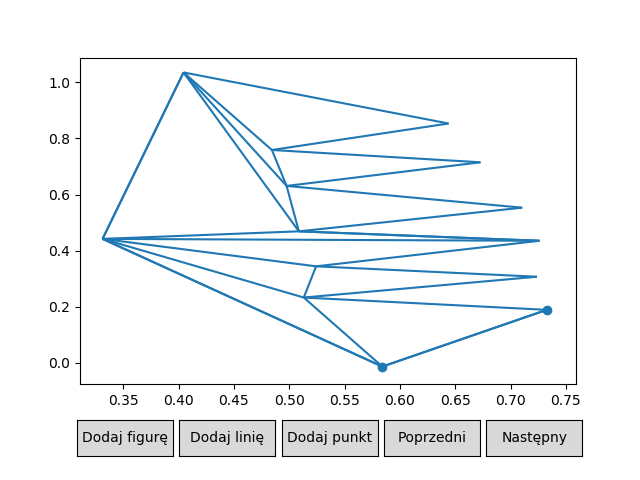

In [276]:
%matplotlib notebook
scenes = triangle(points2, segments2)
plot = Plot(scenes)
plot.draw()